# CITS5014/15 Research Project

### Name: Peter Millitz [23088298]   Date: 17/10/2025

# Deep-Learning-Based Techniques for Ship Object Detection and Classification Using Complex-Valued SAR Imagery

## \[Part 2: Model Training and Evaluation\]

## 1. Modelling

### Custom Dataset class and image resizing function (**enhanced versions - not deployed yet**)

In [6]:
import numpy as np
import cv2

def letterbox_resize(image, labels, new_shape=640, color=(0.1, 0.1, 0.1), scaleup=True):
    """
    Resize image and bounding boxes using letterbox method.

    Args:
        image (ndarray):   Input image with shape (H, W, C) and normalised values [0, 1].
        labels (ndarray):  Bounding boxes in normalised YOLO format (cls xc yc w h).
        new_shape: (int or tuple): Desired output shape (H, W).
        color: (float tuple): Normalised RGB values for padding.
        scaleup (bool): Allow scaling up images smaller than target size.

    Returns:
        image_resized (ndarray): Resized and padded image (H', W', C).
        labels (ndarray):        Adjusted normalised bounding boxes (cls xc yc w h).
    """
    shape = image.shape[:2]  # current shape [height, width]

    # Handle new_shape as int or tuple
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    target_h, target_w = new_shape

    # Compute scale ratio and padding
    r = min(target_h / shape[0], target_w / shape[1])
    if not scaleup:
        r = min(r, 1.0)

    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))  # (w, h)
    dw = target_w - new_unpad[0]
    dh = target_h - new_unpad[1]
    dw /= 2
    dh /= 2

    # Resize and pad
    image_resized = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    image_resized = cv2.copyMakeBorder(image_resized, top, bottom, left, right,
                                       cv2.BORDER_CONSTANT, value=color)

    # Adjust labels
    if labels.size > 0:
        labels[:, 1] = r * labels[:, 1] + left    # x_center
        labels[:, 2] = r * labels[:, 2] + top     # y_center
        labels[:, 3] = r * labels[:, 3]           # width
        labels[:, 4] = r * labels[:, 4]           # height
        labels[:, [1, 3]] /= target_w             # normalize x, w
        labels[:, [2, 4]] /= target_h             # normalize y, h

    return image_resized, labels


In [7]:
# sar_dataset.py - Enhanced SARPreprocessedDataset

import os
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset
#from letterbox_resize import letterbox_resize  # custom function

class SARPreprocessedDataset(Dataset):
    def __init__(self, image_dir, label_dir, imgsz=640):
        """
        Args:
            image_dir (str): Path to directory containing .npy image files
            label_dir (str): Path to directory containing YOLO-format .txt label files
            imgsz (int or tuple): New shape for resizing. Can be int (square) or tuple (H, W)
        """
        self.imgsz = (imgsz, imgsz) if isinstance(imgsz, int) else imgsz

        self.image_label_pairs = []
        for fname in sorted(os.listdir(image_dir)):
            if not fname.endswith('.npy'):
                continue
            image_path = os.path.join(image_dir, fname)
            label_name = fname.replace('_proc.npy', '.txt')
            label_path = os.path.join(label_dir, label_name)
            self.image_label_pairs.append((image_path, label_path))

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label_path = self.image_label_pairs[idx]

        # Load image
        im = np.load(image_path)  # (3, H, W)
        assert im.shape[0] == 3, f"Expected 3-channel image, got shape {im.shape}"
        im = np.transpose(im, (1, 2, 0))  # → (H, W, 3)

        # Load labels
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = np.loadtxt(label_path, ndmin=2, dtype=np.float32)
        else:
            labels = np.zeros((0, 5), dtype=np.float32)

        # Un-normalize bbox coordinates to pixels
        h0, w0 = im.shape[:2]
        if labels.size > 0:
            labels[:, 1] *= w0  # center x
            labels[:, 2] *= h0  # center y
            labels[:, 3] *= w0  # width
            labels[:, 4] *= h0  # height

        # Apply letterbox resize to both image and labels
        im, labels = letterbox_resize(im, labels, new_shape=self.imgsz)

        # Convert image to PyTorch tensor (C, H, W)
        im = torch.from_numpy(im).permute(2, 0, 1).float().contiguous()
        labels = torch.from_numpy(labels).float()

        # Optional unit test: check that normalized labels are in [0, 1]
        if labels.size(0):
            if not ((0 <= labels[:, 1:]).all() and (labels[:, 1:] <= 1).all()):
                raise ValueError(f"Labels out of bounds after resizing: {labels}")

        return im, labels


In [8]:
# Check #1 after building the data set
ds = SARPreprocessedDataset("../modelling/data/train/images", "../modelling/data/train/labels", imgsz=640)
img, label = ds[0]
print(f"First image in ds tensor shape: {img.shape}")   # torch.Size([3, 640, 640])
print(f"First label in ds tensor shape: {label.shape}") # (N, 5) if N objects
print(f"First label in ds tenosr form content: {label}")

First image in ds tensor shape: torch.Size([3, 640, 640])
First label in ds tensor shape: torch.Size([1, 5])
First label in ds tenosr form content: tensor([[0.0000, 0.4896, 0.5000, 0.5208, 0.1458]])


✅ image has been resized labels appear correct

In [9]:
# Check #2 after building the data set
for i in range(img.shape[0]):
    print(f"Channel {i}: min={img[i].min().item()}, max={img[i].max().item()}, mean={img[i].mean().item()}")

Channel 0: min=0.02035709097981453, max=1.0, mean=0.9084838628768921
Channel 1: min=1.7277152437600307e-05, max=1.0, mean=0.502548098564148
Channel 2: min=0.0, max=0.9999907612800598, mean=0.5069760084152222


✅ channel ranges are as expected

In [10]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_random_samples(dataset, n=5, class_names=None, seed=None):
    """
    Randomly select N samples from the dataset and visualize channel-1 magnitude with bounding boxes and labels using Matplotlib.

    Args:
        dataset (Dataset): Your SARPreprocessedDataset instance.
        n (int): Number of random images to visualize.
        class_names (list of str, optional): Class name list for labeling.
        seed (int, optional): Random seed for reproducibility.
    """
    if seed is not None:
        random.seed(seed)

    indices = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))

    if n == 1:
        axs = [axs]

    for ax, idx in zip(axs, indices):
        img_tensor, labels = dataset[idx]

        # Extract magnitude channel (channel 1)
        img_np = img_tensor[0].cpu().numpy()

        # Logarithmic scaling (dB conversion)
        #epsilon = np.float32(1e-6)
        #img_np = np.log10(img_np + epsilon) * np.float32(20)

        # Display image
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Sample {idx}")

        h, w = img_np.shape

        for label in labels:
            cls, xc, yc, bw, bh = label.tolist()
            xc *= w
            yc *= h
            bw *= w
            bh *= h
            x1 = xc - bw / 2
            y1 = yc - bh / 2

            # Draw rectangle
            rect = patches.Rectangle(
                (x1, y1), bw, bh,
                linewidth=1.5,
                edgecolor='lime',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Draw label
            if class_names:
                text = class_names[int(cls)]
                ax.text(
                    x1, y1 - 10, text,
                    fontsize=12,
                    color='lime',
                    verticalalignment='bottom',
                    bbox=dict(facecolor='black', alpha=0.6, pad=1)
                )

    plt.tight_layout()
    plt.show()

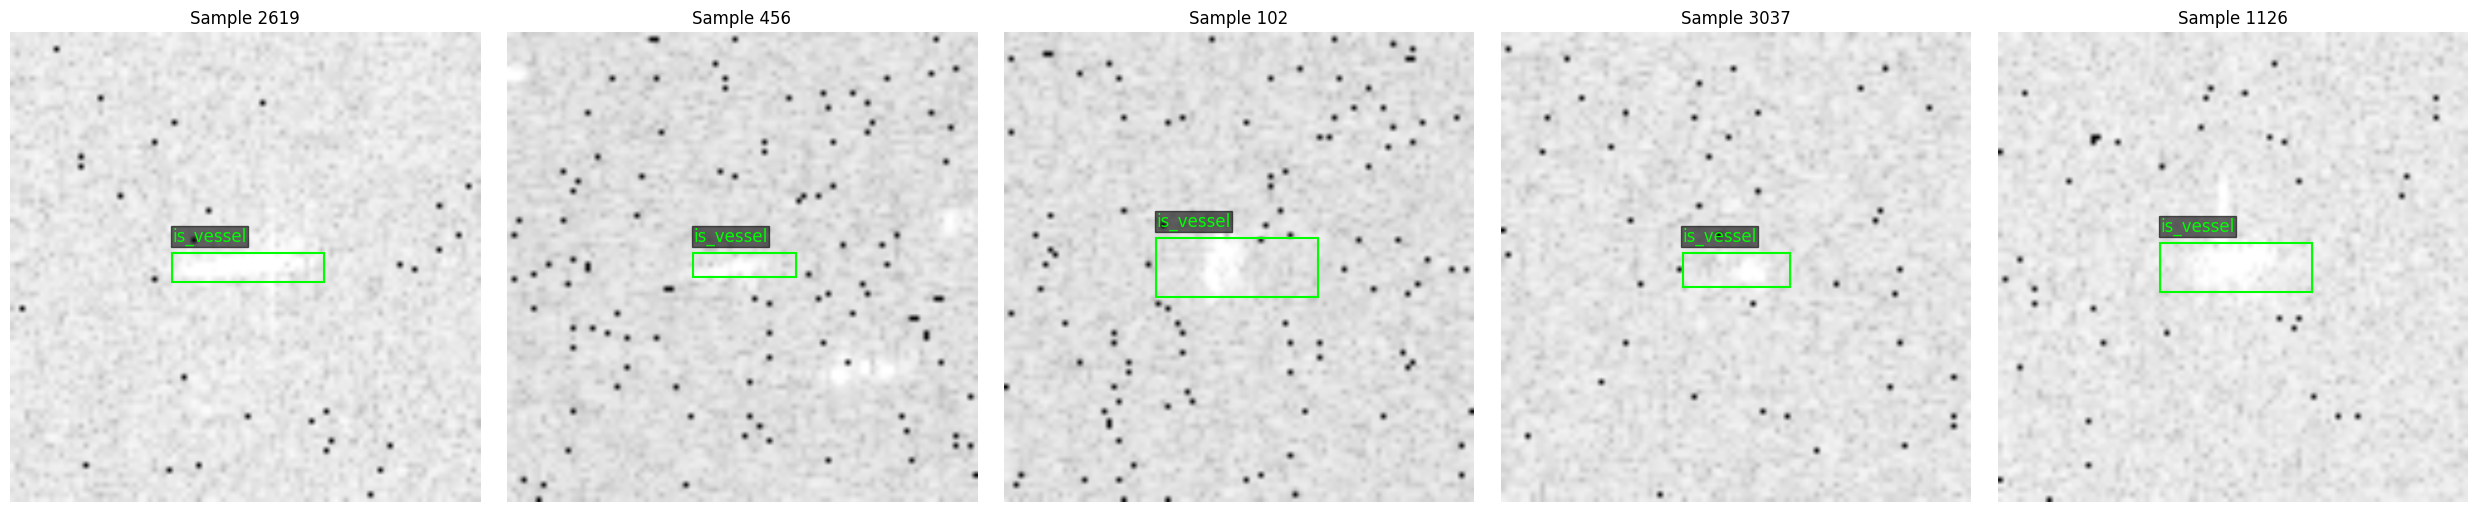

In [11]:
# Check #3 after building dataset
class_names = ['is_vessel', 'is_fishing']
visualize_random_samples(ds, n=5, class_names=class_names, seed=42)

✅ bounding boxes are correctly positioned